In [79]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
from datetime import datetime
from tqdm import tqdm

Analysis based on **LNDB.info - The Light Novel Database** (http://lndb.info)

Code confirmed working on **May 25, 2019**

In [125]:
class Crawler:
    """All the necessary pieces of code to obtain data from LNDB
    """
    def get_search_url(self,year,month):
        """LNDB's Light Novel search
        """
        search_url=\
        "http://lndb.info/releases?show=label&target_readership=undefined&only_titles=true&year={}&month={}"\
        .format(year,month)
        return search_url
    
    def get_links_by_url(self,url):
        """Find all hyperlinks the in the page given by the search url
        """
        base_url="http://lndb.info"
        try:
            res=requests.get(url,timeout=30)
        except:
            print("Page load failed")
            return
        soup = BeautifulSoup(res.text, "html.parser")
        elem_lists=soup.find_all("li",class_="releasebytitle")
        hrefs=[base_url+elem_list.a["href"] for elem_list in elem_lists]
        return hrefs
    
    def count_books_by_yearmonth(self,year,month):
        """Self-explanatory"""
        return len(get_links_by_url(get_search_url(year,month)))
    
    def count_books_by_year(self,year):
        """Self-explanatory"""
        total=0
        for month in range(1,13):
            total=total+count_books_by_yearmonth(year,month)
        return total
    
    def get_cover_img(self,ln_data_url):
        """Get the cover image of a light novel in binary string
        based on the url of the light novel data page
        as given by method get_links_by_url
        """
        base_url="http://lndb.info"
        try:
            res=requests.get(ln_data_url,timeout=30)
        except:
            print("Page load failed")
            return
        soup = BeautifulSoup(res.text, "html.parser")
        img_url=base_url+soup.find("div",class_="left-volume-image").img["src"]
        try:
            res=requests.get(img_url,timeout=30)
        except:
            print("Image download failed")
            return
        return res.content
    
    def show_cover_img(self,img_bin):
        """Show image based on binary of image retrieved by method get_cover_img"""
        plt.figure(figsize=(10,10))
        with Image.open(BytesIO(img_bin)) as img:
            plt.imshow(img)
            
    def get_img_dim(self,img_bin):
        """Get the width and height of binary image.
        Returns (width,height)"""
        with Image.open(BytesIO(img_bin)) as img:
            width=img.size[0]
            height=img.size[1]
            return width,height
        
    def get_novel_info(self,url):
        """Extract information of light novel from light novel data page url"""
        try:
            res=requests.get(url,timeout=30)
        except:
            print("Page load failed")
            return
        soup = BeautifulSoup(res.text, "html.parser")
        elems_label=soup.find_all("td",class_="secondary-volume-info-title")
        list_label=[elem_label.text.strip() for elem_label in elems_label]
        try:
            idx=list_label.index("ISBN-13")
            isbn=elems_label[idx].find_next_sibling("td").text.strip()
        except:
            isbn=np.nan
        try:
            idx=list_label.index("Illustrator")
            illustrator=elems_label[idx].find_next_sibling("td").text.strip()
        except:
            illustrator=np.nan
        try:
            idx=list_label.index("Japanese Volume Title")
            title=elems_label[idx].find_next_sibling("td").text.strip()
        except:
            title=np.nan
        try:
            idx=list_label.index("Volume")
            volumn=elems_label[idx].find_next_sibling("td").text.strip()
        except:
            volumn=np.nan
        try:
            idx=list_label.index("Release Date")
            date=elems_label[idx].find_next_sibling("td").text.strip()
        except:
            date=np.nan
        dt_date=datetime.strptime(date, "%B %d, %Y")
        year=dt_date.year
        month=dt_date.month
        return {"isbn":isbn, "year":year, "month":month, "title":title, "volumn":volumn, "illustrator":illustrator}

In [134]:
class Analyzer:
    """Analysis utilities based on Crawler"""
    def get_cover_data(self,url):
        """Get a dictionary with light novel information and cover image by the url of the light novel data page"""
        crawler=Crawler()
        info=crawler.get_novel_info(url)
        cover=crawler.get_cover_img(url)
        return {**info,"cover":cover}
        
    def get_cover_df(self,year,month):
        """Get the dataframe containing all the cover data for light novels published in year,month"""
        crawler=Crawler()
        urls=get_links_by_url(get_search_url(year,month))
        data_df={"ISBN":[],"PublishYear":[],"PublishMonth":[],"Title":[],"Volumn":[],"Illustrator":[],"Cover":[]}
        with tqdm(total=len(urls)) as bar:
            for url in urls:
                cover_data=get_cover_data(url)
                data_df["ISBN"].append(cover_data["isbn"])
                data_df["PublishYear"].append(cover_data["year"])
                data_df["PublishMonth"].append(cover_data["month"])
                data_df["Title"].append(cover_data["title"])
                data_df["Volumn"].append(cover_data["volumn"])
                data_df["Illustrator"].append(cover_data["illustrator"])
                data_df["Cover"].append(cover_data["cover"])
                bar.update(1)
        df=pd.DataFrame(data_df,columns=["ISBN","PublishYear","PublishMonth","Title","Volumn","Illustrator","Cover"])
        return df
    def show_cover_img(self,img_bin):
        """Show image based on binary of image retrieved by method get_cover_img"""
        plt.figure(figsize=(10,10))
        with Image.open(BytesIO(img_bin)) as img:
            plt.imshow(img)

In [128]:
analyzer=Analyzer()
df=analyzer.get_cover_df(2018,5)

100%|██████████| 63/63 [01:33<00:00,  1.32s/it]


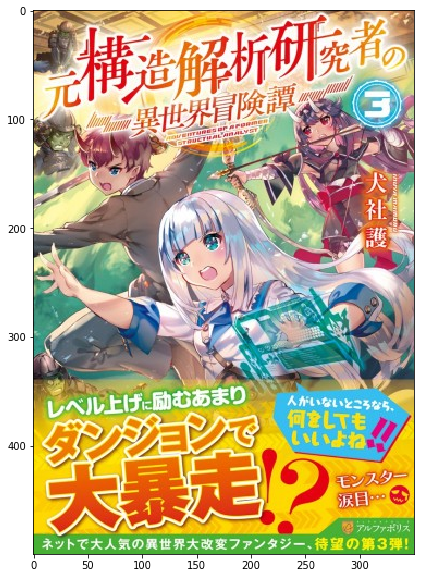

In [133]:
analyzer.show_cover_img(df.loc[0,"Cover"])